In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import xgboost as xgb
from sklearn.cross_validation import train_test_split

from gini import normalized_gini, gini_eval
from dataset import get_data

from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity, KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

params = pd.DataFrame({
    "objective": "reg:linear",
    "eta": [0.04, 0.03, 0.03, 0.03, 0.02],
    "min_child_weight": 5,
    "subsample": [1, 0.9, 0.95, 1, 0.6],
    "colsample_bytree": [0.7, 0.6, 0.65, 0.6, 0.85],
    "max_depth": [8, 7, 9, 10, 10],
    "eval_metric": "auc",
    "scale_pos_weight": 1,
    "silent": 0
})


dat_x_orig, dat_y_orig, lb_x_orig, lb_ind_orig = get_data()
dat_x = dat_x_orig
dat_y = dat_y_orig
lb_x = lb_x_orig
lb_ind = lb_x_orig

In [ ]:
np.asarray(dat_y)

In [2]:
seen_index, cv2_index = train_test_split(range(dat_x_orig.shape[0]), test_size=0.1, random_state=11101)

seen_x = dat_x.iloc[seen_index]
seen_y = dat_y[seen_index]
cv2_x = dat_x.iloc[cv2_index]
cv2_y = dat_y[cv2_index]

train_index, cv1_index = train_test_split(range(seen_x.shape[0]), test_size=0.1, random_state=11103)

train_x = seen_x.iloc[train_index]
train_y = seen_y[train_index]
cv1_x = seen_x.iloc[cv1_index]
cv1_y = seen_y[cv1_index]

print("train shape: %s, cv1 shape: %s, cv2 shape: %s"%(str(train_x.shape), str(cv1_x.shape), str(cv2_x.shape)))

train shape: (41309, 38), cv1 shape: (4590, 38), cv2 shape: (5100, 38)


In [3]:
# DATA FOR XGB
xgb_train = xgb.DMatrix(train_x, label=train_y)
xgb_cv1 = xgb.DMatrix(cv1_x, label=cv1_y)
xgb_cv2 = xgb.DMatrix(cv2_x, label=cv2_y)
watchlist = [(xgb_cv2, 'cv2'), (xgb_cv1, 'cv1')]

/usr/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


In [4]:
def evaluate(true_y, pred_y, label):
    mse = sum(np.power( pred_y - true_y, 2 ))/true_y.shape[0]
    gini = normalized_gini(true_y, pred_y)
    print("%s: Gini=%0.5f, MSE=%0.3f, "%(label, gini, mse))
    return (mse, gini)

In [5]:
cv1_blend_x = np.empty_like(cv1_y)
cv2_blend_x = np.empty_like(cv2_y)

MODELS = 3
cv1_errors = np.empty([1, 2])
cv2_errors = np.empty([1, 2])

for model_number in range(MODELS):
    model = xgb.train(params.iloc[model_number].to_dict(), xgb_train, num_boost_round = 3000,
                      evals = watchlist,
                      feval = gini_eval,
                      verbose_eval = False,
                      early_stopping_rounds=50)

    cv1_y_preds = model.predict(xgb_cv1, ntree_limit=model.best_iteration)
    cv2_y_preds = model.predict(xgb_cv2, ntree_limit=model.best_iteration)

    cv1_errors = np.vstack((cv1_errors, np.asarray(evaluate(cv1_y, cv1_y_preds, "cv1 #%d" % model_number))))
    cv2_errors = np.vstack((cv2_errors, np.asarray(evaluate(cv2_y, cv2_y_preds, "cv2 #%d" % model_number))))
    
    cv1_blend_x = np.vstack( (cv1_blend_x, cv1_y_preds))
    cv2_blend_x = np.vstack( (cv2_blend_x, cv2_y_preds))
    
cv1_blend_x = cv1_blend_x[1:].T    
cv2_blend_x = cv2_blend_x[1:].T    
cv1_errors = cv1_errors[1:].T
cv2_errors = cv2_errors[1:].T

Will train until cv1 error hasn't decreased in 50 rounds.
Stopping. Best iteration:
[129]	cv2-Gini:0.387476	cv1-Gini:0.393520

Will train until cv1 error hasn't decreased in 50 rounds.
Stopping. Best iteration:
[270]	cv2-Gini:0.397285	cv1-Gini:0.397057



cv1 #0: Gini=0.39346, MSE=14.104, 
cv2 #0: Gini=0.38729, MSE=15.213, 
cv1 #1: Gini=0.39701, MSE=14.013, 

Will train until cv1 error hasn't decreased in 50 rounds.
Stopping. Best iteration:
[161]	cv2-Gini:0.388376	cv1-Gini:0.394748




cv2 #1: Gini=0.39715, MSE=15.033, 
cv1 #2: Gini=0.39465, MSE=14.050, 
cv2 #2: Gini=0.38848, MSE=15.122, 


In [27]:
print("Avg cv1: %0.5f cv2: %0.5f" %(np.mean(cv1_errors[1]), np.mean(cv2_errors[1])))

lr1 = LinearRegression()
lr1.fit(cv1_blend_x, cv1_y)
cv1_blend_y_1 = lr1.predict(cv1_blend_x)
cv2_blend_y_1 = lr1.predict(cv2_blend_x)
evaluate(cv1_y, cv1_blend_y_1, "    cv1 with fit to cv1")
evaluate(cv2_y, cv2_blend_y_1, "(*) cv2 with fit to cv1")

lr2 = LinearRegression()
lr2.fit(cv2_blend_x, cv2_y)
cv1_blend_y_2 = lr2.predict(cv1_blend_x)
cv2_blend_y_2 = lr2.predict(cv2_blend_x)
evaluate(cv1_y, cv1_blend_y_2, "    cv1 with fit to cv2")
evaluate(cv2_y, cv2_blend_y_2, "    cv2 with fit to cv2")

Avg cv1: 0.39504 cv2: 0.39097
    cv1 with fit to cv1: Gini=0.39771, MSE=13.992, 
(*) cv2 with fit to cv1: Gini=0.39616, MSE=15.040, 
    cv1 with fit to cv2: Gini=0.39523, MSE=14.015, 
    cv2 with fit to cv2: Gini=0.39611, MSE=15.015, 


(15.015372023022781, 0.3961118666666787)

In [ ]:
np.mean([0.39047, 0.39053, 0.38797, 0.39050, 0.38861])
np.mean([0.37957, 0.38322, 0.38698, 0.38571, 0.38232])


In [7]:
max_cy = max(c1v_y) * 1.1

#plt.subplot(1, 2, 1)
plt.scatter(cv1_y, cv_y_preds, s=1)
plt.xlim(0, 70)

preds = pd.DataFrame({"actual": cv_y, "pred": cv_y_preds})
preds.boxplot('pred', 'actual')

plt.show()

NameError: name 'cv_y' is not defined

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
np.asarray((2,3))

In [ ]:
a = np.array([[2, 3], [4, 5]])
print(a)

In [ ]:
np.repeat(0.0,5), np.zeros(5)

(array([  2.51260000e+04,   1.02980000e+04,   8.33600000e+03,
          4.63300000e+03,   1.73700000e+03,   6.35000000e+02,
          1.76000000e+02,   4.10000000e+01,   1.40000000e+01,
          3.00000000e+00]),
 array([ 1.79175947,  2.04299003,  2.29422059,  2.54545116,  2.79668172,
         3.04791228,  3.29914284,  3.55037341,  3.80160397,  4.05283453,
         4.30406509]),
 <a list of 10 Patch objects>)

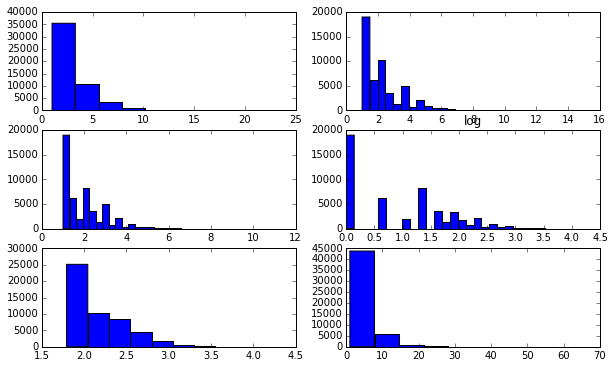

In [42]:
rows = 3
cols = 2
i = 0
plt.subplot(rows,cols,i)
i = i + 1
plt.hist(dat_y)
plt.subplot(rows,cols,i)
i = i + 1
plt.hist(dat_y ** 0.75)
plt.subplot(rows,cols,i)
i = i + 1
plt.hist(dat_y ** 0.65, 30)
plt.subplot(rows,cols,i)
i = i + 1
plt.hist(dat_y ** 0.55, 30)
plt.subplot(rows,cols,i)
i = i + 1
plt.hist(np.log(dat_y), 30)
plt.title("log")
plt.subplot(rows,cols,i)
i = i + 1
plt.hist(np.log(dat_y + 5))

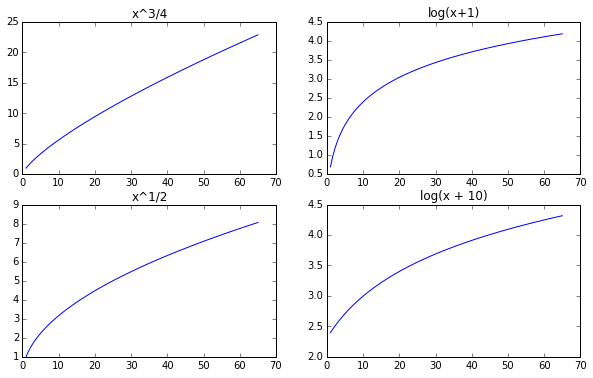

In [26]:
xs = np.linspace(1.0, 65, 100)
plt.subplot(2, 2, 1)
plt.plot(xs, np.power(xs, 0.75))
plt.title("x^3/4")
plt.subplot(2, 2, 2)
plt.plot(xs, np.log(xs + 1))
plt.title("log(x+1)")
plt.subplot(2, 2, 3)
plt.plot(xs, np.power(xs, 0.5))
plt.title("x^1/2")
plt.subplot(2, 2, 4)
plt.plot(xs, np.log(xs + 10))
plt.title("log(x + 10)")